In [1]:
cd ..

C:\Users\688228hh\Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.ContParticleFilter import PFHestonContinuous
from src.Heston import *
from scipy.optimize import minimize
# from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': 0,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.5
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] - params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 0, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

0.15


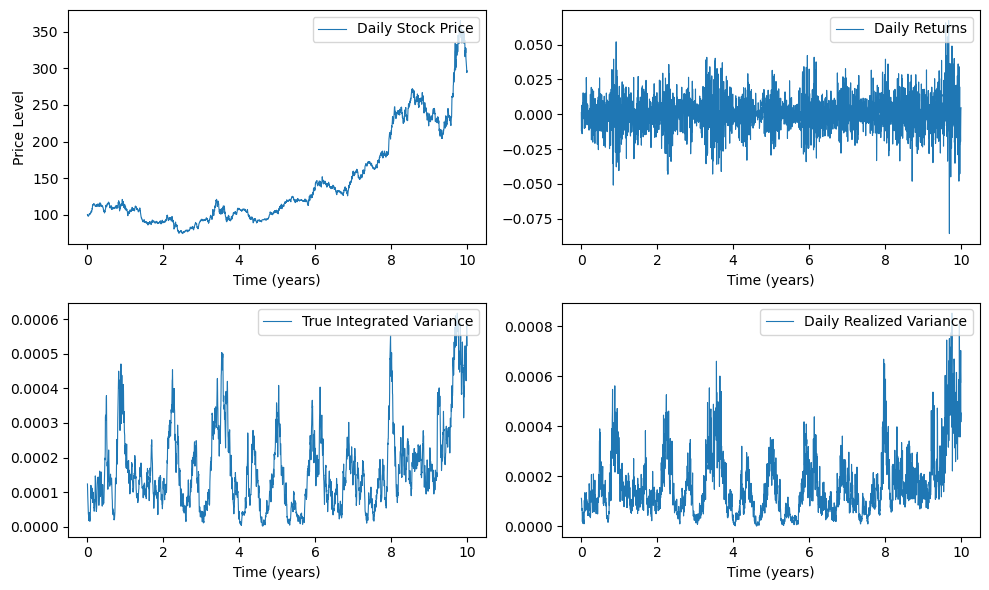

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [6]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.008682
theta: 0.000121
xi: 0.001427
mu: 0.000360
sigma: 0.000001
Negative Log-Likelihood: -14118.299818
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [8.68201159e-03 1.20851733e-04 1.42682645e-03 3.59643084e-04
 1.00000000e-06]


### Both - Corr

In [7]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])

fit_results_both = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both_corr = hkf_both_corr.filter(params_opt_both)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
V_filt_both_test_corr = hkf_both_test_corr.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.008715
theta: 0.000118
xi: 0.001435
mu: 0.000347
sigma: 0.000080
rho: -0.100052
Negative Log-Likelihood: -14118.981861
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 8.71539236e-03  1.18042297e-04  1.43463780e-03  3.46640419e-04
  7.98010115e-05 -1.00051541e-01]


### Return

In [9]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.071210
theta: 0.000154
xi: 0.007123
mu: 0.000276
Negative Log-Likelihood: -3740.503220
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [0.07120976 0.00015442 0.00712343 0.00027606]


### Return - Corr

In [10]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
V_filt_returns_test_corr = hkf_returns_test_corr.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 1.001379
theta: 0.000155
xi: 0.007000
mu: 0.000278
rho: 0.000006
Negative Log-Likelihood: -3739.714244
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [1.00137873e+00 1.54709310e-04 7.00019954e-03 2.77519574e-04
 5.64752644e-06]


### RV

In [11]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
V_filt_rv_test = hkf_rv_test.filter(params=params_opt_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.007088
theta: 0.000129
xi: 0.001838
sigma: 0.002674
Negative Log-Likelihood: -11034.644223
Convergence: True
--------------------------------------------------
Optimized parameters (RV): [0.00708824 0.00012876 0.00183808 0.00267358]


### PF

In [12]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.2, 0.2),    # mu
    (1, 10),        # kappa
    (0.02, 0.1),    # theta
    (0.05, 0.8),    # xi
    (-1, 0),        # rho
    V0              # v0
]

V_pf_train, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
V_pf_train_daily = V_pf_train / 252

resampling since: 1485.226744123162
resampling since: 1561.9794835774128
resampling since: 1428.962888357819
resampling since: 125.3486405341175
resampling since: 808.6010648027187
resampling since: 2050.7108229106616
resampling since: 860.7948986317546
resampling since: 2551.5280406753327
resampling since: 1863.7920951177507
resampling since: 360.4818279258995
resampling since: 2711.1557273149506
resampling since: 3420.794903427351
resampling since: 2366.5401877044587
resampling since: 2923.597947195184
resampling since: 1902.0585864179507
resampling since: 2123.259289909761
resampling since: 2662.2102192452608
resampling since: 561.4062704777617
resampling since: 1784.1364727522491
resampling since: 3324.1517315192314
resampling since: 498.18096057541425
resampling since: 876.3111059229687
resampling since: 1358.671902187232
resampling since: 1797.5459279548497
resampling since: 3070.254707003793
resampling since: 2733.500764245423
resampling since: 3032.5047431793414
resampling sinc

In [13]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

param_bounds_test = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))
param_bounds_test.append(V_pf_train[-1])

V_pf_test, _ = pf_heston_test.filter(param_bounds_test, predict_obs=False)
V_pf_test_daily = V_pf_test / 252

resampling since: 3054.0109939820395
resampling since: 3265.498478706359
resampling since: 3175.6298727098037
resampling since: 2056.610542216044
resampling since: 2181.424829841459
resampling since: 3214.024757909468
resampling since: 2915.2778369375965
resampling since: 3417.402773689312
resampling since: 3409.9405024830007
resampling since: 3431.320857040195
resampling since: 3347.780443261967
resampling since: 3348.2528941997875
resampling since: 3097.8932504038503
resampling since: 3448.2600236814073
resampling since: 3125.9376344849156
resampling since: 3385.1590877833846
resampling since: 2947.5179331622976
resampling since: 3156.590750420965
resampling since: 2912.820601179461
resampling since: 2746.853429489352
resampling since: 3435.29629694149
resampling since: 3159.218945873713
resampling since: 3027.438730138996
resampling since: 3462.3976171407753
resampling since: 3158.9830971021865
resampling since: 3497.7748396115385
resampling since: 3467.9494952358773
resampling sinc

## Plot

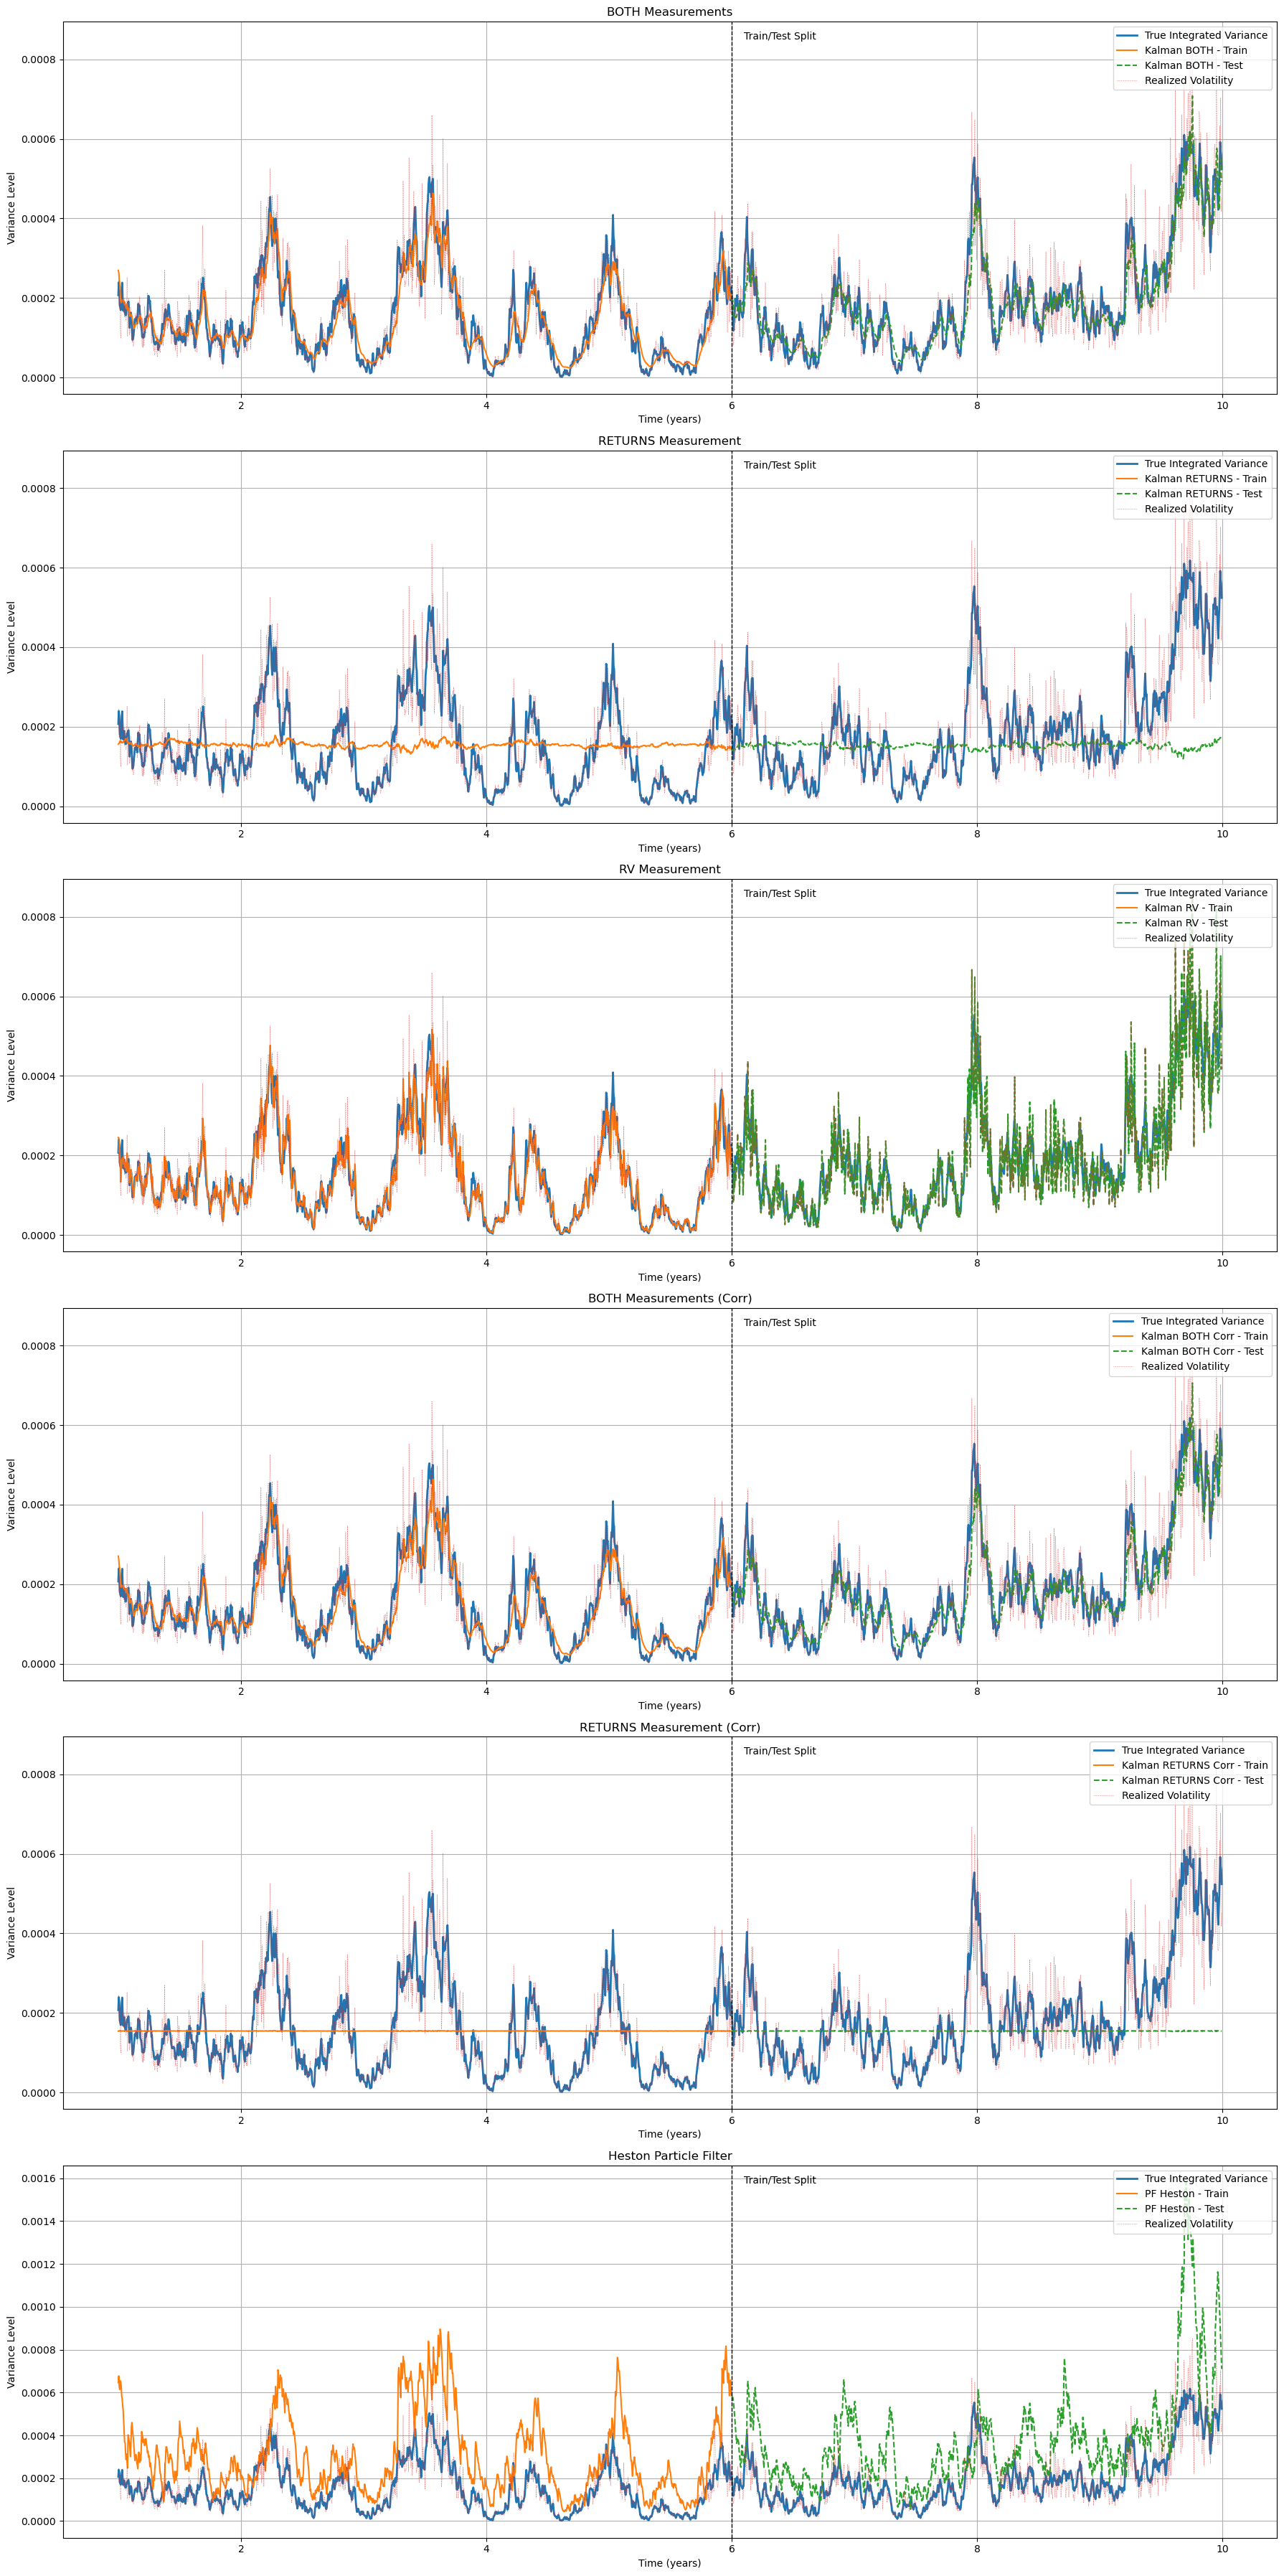

In [14]:
titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "BOTH Measurements (Corr)", "RETURNS Measurement (Corr)", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both['V_filt'], train_result_returns['V_filt'], train_result_rv['V_filt'], train_result_both_corr['V_filt'], train_result_returns_corr['V_filt'], V_pf_train_daily]
test_all = [V_filt_both_test, V_filt_returns_test, V_filt_rv_test, V_filt_both_test_corr, V_filt_returns_test_corr, V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252,
    save_path=r"C:\Users\688228hh\Kalman-Heston-Filter\output\no_leverage.png"
)

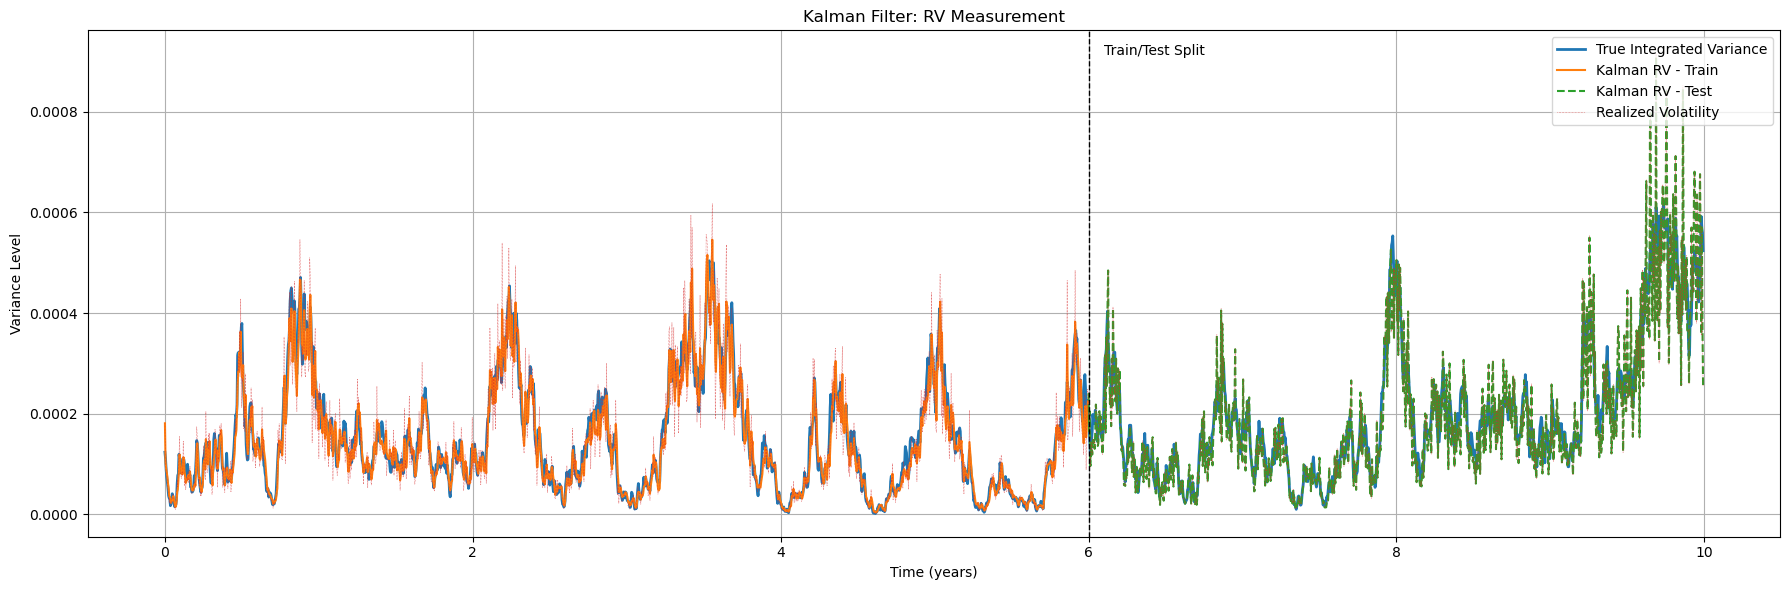

In-Sample RMSE (RV Measurement): 0.000026
Out-of-Sample RMSE (RV Measurement): 0.000055


(2.5867919148173176e-05, 5.4892072600495645e-05)

In [14]:
Utility.plot_filter_result(
    plot_index=2,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)

In [68]:
# Print RMSEs
for k, v in rmse_is_dict.items():
    print(f"In-Sample RMSE ({k}): {v:.6f}")

In-Sample RMSE (BOTH Measurements): 0.000026
In-Sample RMSE (RETURNS Measurement): 0.000043
In-Sample RMSE (RV Measurement): 0.000019


In [69]:
# Print RMSEs
for k, v in rmse_oos_dict.items():
    print(f"Out-of-Sample RMSE ({k}): {v:.6f}")

Out-of-Sample RMSE (BOTH Measurements): 0.000024
Out-of-Sample RMSE (RETURNS Measurement): 0.000107
Out-of-Sample RMSE (RV Measurement): 0.000034
